In [1]:
# Definitions and functions
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob
from __future__ import division
# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))


import soundtools as st
from swissknife.bci.core import expstruct as et
from swissknife.bci.core import kwik_functions as kwkf
from swissknife.bci import synthetic as syn
from swissknife.bci import unitmeta as um
from swissknife.bci import stimalign as sta

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp
#from basic_viewing.structure import kwik_functions as kwf
from swissknife.decoder import linear as ld


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)
logger.debug('all modules loaded')

Computer: passaro


In [2]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
syn_sess = 2
# bird = 'z020'
# sess = 'day-2016-06-03'

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')
kwik_file = et.open_kwik(bird, sess)
kwd_file = et.open_kwd(bird, sess)

In [3]:
song_file_path

'/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-10/experiment.sng.kwe'

In [4]:
reload(et)
prb_par = et.load_probe(bird, sess)
prb_par['channel_groups'][2]['channels']

2017-05-17 22:37:49,226 bci.core.expstruct INFO     probe file: /mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-10/Buzsaki32.prb


[2, 3, 4, 5, 6, 7, 8, 12]

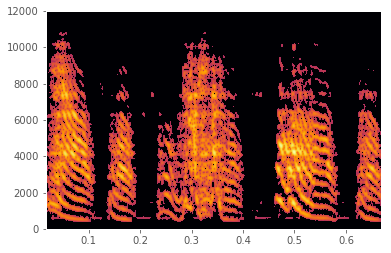

In [5]:
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
m_length = m_chunk.samples
#plt.plot(m_chunk.data)

n_window = 1024
n_overlap = 1023
sigma = 0.001 * 30000
f_cut = 12000
s_f = m_chunk.sound.s_f

pattern_spectrogram = spectrogram(m_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*2), 
                                  scaling='spectrum')

pattern_spectrogram[2][[pattern_spectrogram[2]<np.max((pattern_spectrogram[2])*0.000065)]]=1

plt.figure()
plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]),
               cmap='inferno',
              rasterized=True)
fig_fname = os.path.join(os.path.split(m_path)[0], 'motiff_spectrogram_copper.eps')
plt.savefig(fig_fname, format='eps', dpi=300)

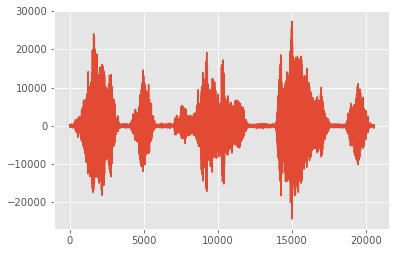

In [6]:
plt.plot(m_chunk.data)

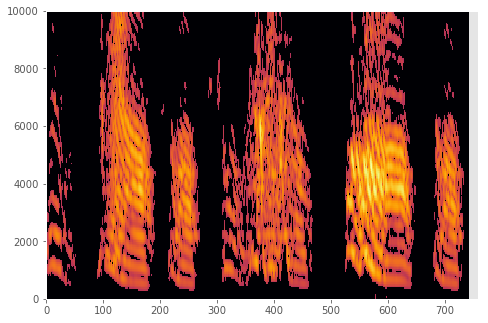

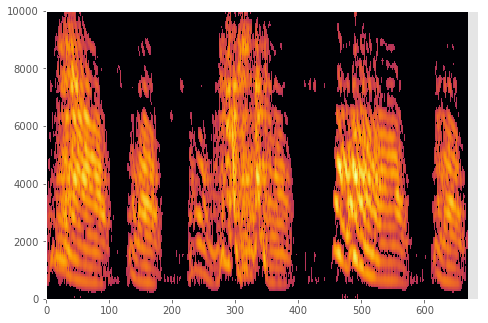

In [7]:
# from __future__ import division
# from scipy.signal import resample

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

n_samples = m_chunk.samples
bos = syn.load_syn_stream(bird, file_base='bos')[:,]

spectr_bos, ax = plot_spectrogram(bos[:], 
                                   0, 0, 30000,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

spectr_pattern, ax = plot_spectrogram(m_chunk.data[:].flatten(), 
                                   0, 0, 30000,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

In [8]:
all_sess_units = um.list_sess_units(bird, sess)

In [9]:
m.get_rec()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4])

In [10]:
m_starts = kwkf.apply_rec_offset(kwik_file, m.get_start(), m.get_rec())

In [11]:
# Neural data
shank = 0

kwik_file = et.open_kwik(bird, sess)
all_units = kwkf.list_units(kwik_file, group=shank, sorted=False)
units_list = [Unit(clu, kwik_file=kwik_file) for clu in all_units.clu]

# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print(all_units['clu'])


[ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52 53
 54 55 56 57 58 59  6 60 61 62 63  7  8  9]


In [12]:
units_list = [Unit(clu, kwik_file=kwik_file) for clu in all_units.clu]

<function ipywidgets.widgets.interaction.<lambda>>

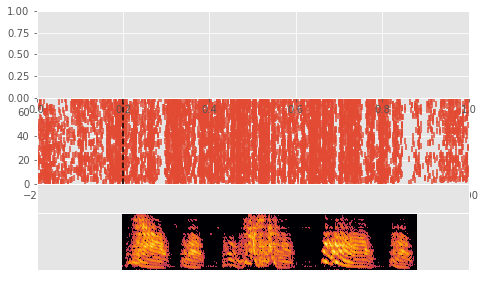

In [13]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def plot_one_raster(unit_clu):
    # instance a Unit object
    unit = Unit(unit_clu, kwik_file=kwik_file)
    # get the spike times (in sample units)
    unit.get_time_stamps()
    # get the sampling rate of the recording
    s_f = unit.sampling_rate
    #get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
    before_ms = 1000
    after_ms = 1600
    start_points = m_starts - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    # the raster is an n_trial * m array (where m can be sample or ms).
    # in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial
    # plot the raster
    b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
    plt.figure(unit_clu)
    plt.scatter(rs, b, marker='|', rasterized=True)
    plt.xlim(0, before_ms + after_ms)
    plt.show
    
class VizUnit():
    def __init__(self, all_units, pattern_chunk, event):
        self.unit = None
        self.raster = None
        self.clu = all_units['clu']
        self.all_units = all_units
        self.is_good = Checkbox()
        self.fig = None
        self.fig_width = 1
        self.fig_ax = {}
        self.pattern_chunk = pattern_chunk
        self.pattern = pattern_chunk.data.reshape(pattern_chunk.data.size,)
        self.before_ms = 200
        self.after_ms = 800
        self.start_points = None
        self.s_f = pattern_chunk.sound.s_f
        self.spectr = None
        self.event = None
        #display(self.is_bout)
        
        self.init_event(event)
        self.init_fig()
        
    def show(self, i):
        i_clu = i
        self.select_unit(i_clu)
        print 'selected unit {0}, clu{1}'.format(i_clu, self.unit.clu)
        ax1 = self.fig_ax['raster']
        ax2 = self.fig_ax['histogram']
        ax1.cla()
        ax2.cla()
        rast, ax1 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, ax=ax1)
        #rast, ax2 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, bin_size=5, ax=ax2)
        display(self.fig)
    
    def select_unit(self, unit_clu):
        self.unit = Unit(unit_clu, kwik_file=kwik_file)
        self.raster = self.unit.get_raster(self.start_points, self.before_ms + self.after_ms, 
                                           span_is_ms=True, return_ms=True)
    
    def init_event(self, event):
        self.event = event
        m_starts = kwkf.apply_rec_offset(kwik_file, self.event.get_start(), self.event.get_rec())
        self.start_points = m_starts - np.int(self.s_f * self.before_ms/1000.)
        
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['raster'] = self.fig.add_axes([0,.3,self.fig_width,0.3])
        self.fig_ax['histogram'] = self.fig.add_axes([0,.6,self.fig_width,0.3])
        self.fig_ax['spectrogram'] = self.fig.add_axes([0,0,self.fig_width,0.2])
        self.fig_ax['synthesis'] = self.fig.add_axes([0,.2,self.fig_width,0.1])
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        self.update_spectrogram()
        #self.update_synth_plot()

    def update_spectrogram(self):
        ax = self.fig_ax['spectrogram']
        m_chunk = self.pattern_chunk
        self.spectr, ax = plot_spectrogram(m_chunk.data.reshape(m_chunk.data.size,), 
                                           self.before_ms, self.after_ms, m_chunk.sound.s_f, 
                                           ax=ax, 
                                           n_window = 192, n_overlap=192-1, scaling='spectrum')
    def update_synth_plot(self):
        ax = self.fig_ax['synthesis']
        ax = plot_waveform(alpha[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        ax = plot_waveform(beta[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        
        
        
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.candidates.set_value(self.motiff, 'bout', bc['new'])
    # inspect the result

vu = VizUnit(all_units, m_chunk, m)
widgets.interact(vu.show, i=(0, all_units['clu'].size-1, 1))

In [14]:
# load the fitted syllables
all_fit_syl = pd.concat([pd.read_pickle(os.path.join(fn['folders']['ss'], 
                                                     'syllable_pandas_parfit_{}.pickle'.format(syl_type)))
                         for syl_type in ['0', '1', '2', '3', '-1']]).sort_values(by='mot_id')

In [ ]:
all_fit_syl = pd.concat([pd.read_pickle(os.path.join(fn['folders']['ss'], 
                                                     'syllable_pandas_parfit_{}.pickle'.format(syl_type)))
                         for syl_type in ['0',  '-1']]).sort_values(by='mot_id')

In [15]:
filt_syl = all_fit_syl
# load training set
syl_type = 0
test_trials = 0

#filt_syl = pd.read_pickle(os.path.join(fn['folders']['ss'], 'syllable_pandas_parfit.pickle'))
syl_selection = (filt_syl['syl_type']==syl_type) & (filt_syl['keep']==True)
syl_selection = (filt_syl['keep']==True)

select_syl = filt_syl[syl_selection]
total_trials = select_syl.shape[0]

syl_train = select_syl[:total_trials-test_trials].reset_index(drop=True)

syl_test = select_syl[-test_trials:]
#syllables_to_train = 

In [16]:
logger.setLevel(logging.INFO)

In [17]:
syl_train

,alpha,beta,bird,duration,end,env,index,keep,mot_id,mot_start,rec,rw_stream,sess,start,syl_type
0,"[-0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0....","[-0.002, -0.002, -0.002, -0.004, -0.006, -0.01...",z007,93,110,"[0.0231172765544, 0.0249807082261, 0.028788284...",0.0,True,0,1163019,0,"[-100.633334158, -189.647689373, -238.82562900...",day-2016-09-10,17,0
1,"[-0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0....","[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0....",z007,50,191,"[0.0511038905744, 0.0571073640999, 0.060813967...",0.0,True,0,1163019,0,"[167.575225993, 203.687687781, 151.972318857, ...",day-2016-09-10,141,1
2,"[-0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0....","[-0.074, -0.074, -0.068, -0.066, -0.066, -0.06...",z007,118,579,"[0.138643314241, 0.196076136438, 0.26909116357...",0.0,True,0,1163019,0,"[-24.5457695253, 40.4192048106, -98.9316057092...",day-2016-09-10,461,3
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",z007,17,17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,True,0,1163019,0,NaN,day-2016-09-10,0,-1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",z007,31,141,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,True,0,1163019,0,NaN,day-2016-09-10,110,-1
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",z007,44,235,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,True,0,1163019,0,NaN,day-2016-09-10,191,-1
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",z007,64,461,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,True,0,1163019,0,NaN,day-2016-09-10,397,-1
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",z007,20,599,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,True,0,1163019,0,NaN,day-2016-09-10,579,-1
8,"[-0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0....","[-0.002, -0.002, -0.002, -0.004, -0.006, -0.01...",z007,162,397,"[0.0198623841999, 0.0214104415557, 0.023119179...",0.0,True,0,1163019,0,"[110.035704497, 134.53134729, 161.326718198, 2...",day-2016-09-10,235,2
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",z007,63,459,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,True,1,1089649,0,NaN,day-2016-09-10,396,-1


In [56]:
(syl_train.start.as_matrix()).astype(np.int)

array([ 17, 141, 461,   0, 110, 191, 397, 579, 235, 396, 578, 193, 114,
       237, 459,   0,  18, 141, 458, 143, 236,   0, 116, 193,  22, 576,
       395, 459, 238, 578, 394, 195, 115,   0,  23, 146, 576, 457, 237,
        23,   0, 116, 197, 395, 144, 460,   0, 139,  16, 235, 111, 190,
       397, 582, 140, 581, 397, 460, 190, 111,  16,   0, 235, 583, 138,
       234, 106,   0, 462,  11, 396, 188, 108, 461, 237, 582,   0, 394,
       187, 136,  12, 459, 235, 582, 191, 110,   0, 396,  15, 139,  12,
         0, 106, 462, 237, 187, 393, 581, 110, 190, 394,   0, 581, 235,
        15, 461, 140,   0, 237,  19, 460, 115, 142, 397, 579, 193, 234,
       462, 139,  15, 397,   0, 581, 191, 113, 139,   0, 113, 192, 401,
       583,  15, 235, 462,  17, 461, 580, 400, 194,   0, 236, 115, 461,
        17, 195,   0, 237, 115, 580, 399, 397, 235, 459, 196, 142,   0,
       118, 580,  18, 461, 194, 114,   0, 396, 579,  15, 140, 235, 237,
       143,   0, 459,  20, 116, 193, 396, 576, 578, 397, 196, 11

In [19]:
from basic_viewing import units as u
reload(ld)
reload(u)
from tqdm import tqdm

bin_size = 5

history_bins = 15

ms_to_samp = s_f//1000.
# get all the syllable starts within the kwik file at once
syl_starts = (syl_train.start.as_matrix() * ms_to_samp + syl_train.mot_start.as_matrix()).astype(np.int)
syl_recs = syl_train.rec.as_matrix().astype(np.int)
syl_starts_kwik = kwkf.apply_rec_offset(kwik_file, syl_starts, syl_recs)

all_sv = []
all_target = []

def regularize_pars(x):
    # 3 cols: alpha, beta, env
    alpha = np.zeros_like(x[0])
    alpha[x[0]<=0] = 0
    beta = syn.np_mulog(-x[1]/2.5)
    env = syn.np_mulog(x[2])
    return np.stack([alpha, beta, env])

for i_syl, syl in tqdm(syl_train.iterrows()):
    #print(i_syl)
    len_ms = int(syl['duration'])
    len_samples = int(syl['duration'] * ms_to_samp)
    pars_ms = np.stack([np.array(syl[p_name]) for p_name in ['alpha', 'beta', 'env']])[:,:len_ms]
    pars_ms = regularize_pars(pars_ms)
    model_pars = bp.col_binned(pars_ms, bin_size)/bin_size
    this_sv, ths_sv_u = u.support_vector(np.array([syl_starts_kwik[i_syl]]), len_samples, units_list,
                                        bin_size = bin_size,
                                        history_bins = history_bins+1,
                                        no_silent=False)
    all_sv.append(this_sv)
    all_target.append(model_pars)
    #print(len_samples)

574it [01:22,  6.61it/s]


In [20]:
pars_ms.shape

(3, 20)

In [21]:
this_sv.shape

(64, 20, 1)

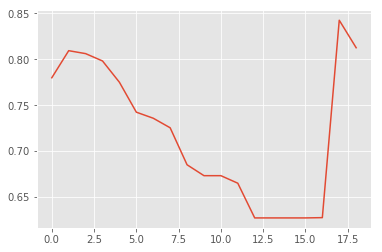

In [25]:
plt.plot(syn.np_mulog(all_target[250][1]))

In [26]:
from swissknife.decoder.core import datashape as ds
big_r, target = ds.data_arrange(all_sv[6], all_target[6][0].reshape([1, -1]), history_bins)

2017-05-17 14:11:55,226 decoder.datashape WARNING  Size mismatch between target and support vector


In [27]:
big_r.shape

(13, 961)

In [28]:
target.shape

(13,)

In [29]:
a = range(10)
a[:-2]

[0, 1, 2, 3, 4, 5, 6, 7]

In [30]:
def sup_list_to_keras(sv_list, target_list, history_bins, n_test=5):
    big_r_stack = []
    targets_stack = []
    for one_sv, one_target in tqdm(zip(sv_list, target_list)):
        big_r, target = ds.data_arrange(one_sv, one_target[0].reshape([1, -1]), history_bins)
        target_len = target.shape[0]
        three_targets = one_target[:, :target_len].T
        big_r_stack.append(big_r)
        targets_stack.append(three_targets)
        #print(big_r.shape)
        
    x_train = np.concatenate(big_r_stack[:-n_test], axis=0)
    y_train = np.concatenate(targets_stack[:-n_test], axis=0)
    
    x_test = np.concatenate(big_r_stack[-n_test:], axis=0)
    y_test = np.concatenate(targets_stack[-n_test:], axis=0)
    return x_train, y_train, x_test, y_test

X, Y , X_test, Y_test = sup_list_to_keras(all_sv, all_target, history_bins)

print(X.shape)
print(Y.shape)

  0%|          | 0/574 [00:00<?, ?it/s]2017-05-17 14:12:07,517 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,519 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,521 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,522 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,524 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,525 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,527 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,528 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,529 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,531 decoder.datashape WARNING  Size mismatch betwe

2017-05-17 14:12:07,623 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,624 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,626 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,627 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,627 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,628 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,629 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,631 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,632 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,634 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17

2017-05-17 14:12:07,694 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,695 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,697 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,698 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,699 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,701 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,702 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,703 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,704 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,705 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17

2017-05-17 14:12:07,785 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,786 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,787 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,788 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,789 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,790 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,791 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,792 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,793 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,794 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17

2017-05-17 14:12:07,883 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,886 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,887 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,888 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,889 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,891 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,892 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,893 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,894 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,895 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17

2017-05-17 14:12:07,975 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,976 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,976 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,977 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,979 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,979 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,981 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,982 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,983 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:07,985 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17

2017-05-17 14:12:08,056 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,057 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,058 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,059 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,060 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,061 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,062 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,062 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,063 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17 14:12:08,064 decoder.datashape WARNING  Size mismatch between target and support vector
2017-05-17

(7886, 961)
(7886, 3)


In [31]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

Using TensorFlow backend.


In [32]:
n_feat = X.shape[1]
n_test = 10

model = Sequential()
model.add(Dense(n_feat//2, input_dim=n_feat, kernel_initializer='uniform', activation='relu'))
model.add(Dense(320, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_absolute_error', optimizer='rmsprop')



model.fit(X, Y[:,1], epochs=300, batch_size=10, verbose=2, validation_split=0.1)
score = model.evaluate(X_t, Y_t[:,1], batch_size=10)

Train on 7097 samples, validate on 789 samples
Epoch 1/300
2s - loss: 0.0653 - val_loss: 0.0655
Epoch 2/300
1s - loss: 0.0472 - val_loss: 0.0444
Epoch 3/300
1s - loss: 0.0406 - val_loss: 0.0438
Epoch 4/300
1s - loss: 0.0354 - val_loss: 0.0405
Epoch 5/300
1s - loss: 0.0319 - val_loss: 0.0440
Epoch 6/300
1s - loss: 0.0291 - val_loss: 0.0374
Epoch 7/300
1s - loss: 0.0262 - val_loss: 0.0470
Epoch 8/300
1s - loss: 0.0241 - val_loss: 0.0373
Epoch 9/300
1s - loss: 0.0222 - val_loss: 0.0423
Epoch 10/300
1s - loss: 0.0208 - val_loss: 0.0392
Epoch 11/300
1s - loss: 0.0196 - val_loss: 0.0388
Epoch 12/300
1s - loss: 0.0182 - val_loss: 0.0382
Epoch 13/300
1s - loss: 0.0178 - val_loss: 0.0415
Epoch 14/300
1s - loss: 0.0169 - val_loss: 0.0379
Epoch 15/300
1s - loss: 0.0159 - val_loss: 0.0380
Epoch 16/300
1s - loss: 0.0152 - val_loss: 0.0374
Epoch 17/300
1s - loss: 0.0146 - val_loss: 0.0401
Epoch 18/300
1s - loss: 0.0143 - val_loss: 0.0405
Epoch 19/300
1s - loss: 0.0138 - val_loss: 0.0398
Epoch 20/300

1s - loss: 0.0047 - val_loss: 0.0402
Epoch 164/300
1s - loss: 0.0050 - val_loss: 0.0379
Epoch 165/300
1s - loss: 0.0049 - val_loss: 0.0396
Epoch 166/300
1s - loss: 0.0048 - val_loss: 0.0387
Epoch 167/300
1s - loss: 0.0047 - val_loss: 0.0393
Epoch 168/300
1s - loss: 0.0048 - val_loss: 0.0400
Epoch 169/300
1s - loss: 0.0049 - val_loss: 0.0387
Epoch 170/300
1s - loss: 0.0051 - val_loss: 0.0376
Epoch 171/300
1s - loss: 0.0048 - val_loss: 0.0381
Epoch 172/300
1s - loss: 0.0048 - val_loss: 0.0412
Epoch 173/300
1s - loss: 0.0048 - val_loss: 0.0373
Epoch 174/300
1s - loss: 0.0050 - val_loss: 0.0393
Epoch 175/300
1s - loss: 0.0050 - val_loss: 0.0386
Epoch 176/300
1s - loss: 0.0050 - val_loss: 0.0387
Epoch 177/300
1s - loss: 0.0049 - val_loss: 0.0390
Epoch 178/300
1s - loss: 0.0049 - val_loss: 0.0407
Epoch 179/300
1s - loss: 0.0050 - val_loss: 0.0389
Epoch 180/300
1s - loss: 0.0049 - val_loss: 0.0414
Epoch 181/300
1s - loss: 0.0049 - val_loss: 0.0402
Epoch 182/300
1s - loss: 0.0049 - val_loss: 0

NameError: name 'X_t' is not defined

In [31]:
model_path = os.path.join(fn['folders']['ss'], 'keras_model_4_10.h5')
weights_path = os.path.join(fn['folders']['ss'], 'keras_weights_4_10.h5')
model.save(model_path)
model.save_weights(weights_path)

In [68]:
mp = model.predict(X_test, batch_size=10)
mp.shape

(81, 1)

In [69]:
X_t.shape

(98, 961)

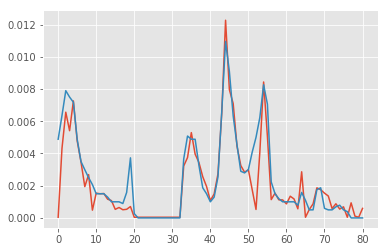

In [71]:
plt.plot(syn.np_mulog_inv(mp))
plt.plot(syn.np_mulog_inv(Y_test[:, 1]))

In [51]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8254895868580491306, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 296878080
 locality {
   bus_id: 1
 }
 incarnation: 7045607212424966810
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:02:00.0"]

In [24]:
import threading
from pycuda import driver

In [32]:
from threadtools import threadedfunction as td

def fit_ffnn(sup_vec, target, hist_bins, hid_dim, 
             n_test=10,
             nb_epoch=500, 
             batch_size=15):
    X_train, Y_train, X_test, Y_test = nd.sup_to_keras(sup_vec, target, history_bins, n_test=n_test)
    n_feat = X_train.shape[1]
    model = Sequential()
    model.add(Dense(hid_dim, input_dim=n_feat, init='uniform', activation='relu'))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=2, validation_split=0.1)
    
    return model, model.predict(X_test, batch_size=15)



ft = [fit_ffnn(sv, t, history_bins, 30) for t in targets]
    


2017-02-07 02:18:07,966 decoder.datashape WARNING  Size mismatch between target and support vector
2017-02-07 02:18:08,112 decoder.neural INFO     Train vector sizes (9943, 560) and (9943,)
2017-02-07 02:18:08,113 decoder.neural INFO     Test vector sizes (1630, 560) and (1630,)


Train on 8948 samples, validate on 995 samples
Epoch 1/500
1s - loss: 0.0716 - val_loss: 0.0654
Epoch 2/500
1s - loss: 0.0478 - val_loss: 0.0453
Epoch 3/500
1s - loss: 0.0383 - val_loss: 0.0427
Epoch 4/500
1s - loss: 0.0326 - val_loss: 0.0427
Epoch 5/500
1s - loss: 0.0286 - val_loss: 0.0386
Epoch 6/500
1s - loss: 0.0258 - val_loss: 0.0415
Epoch 7/500
1s - loss: 0.0234 - val_loss: 0.0368
Epoch 8/500
1s - loss: 0.0218 - val_loss: 0.0345
Epoch 9/500
1s - loss: 0.0197 - val_loss: 0.0335
Epoch 10/500
1s - loss: 0.0189 - val_loss: 0.0345
Epoch 11/500
1s - loss: 0.0179 - val_loss: 0.0338
Epoch 12/500
1s - loss: 0.0172 - val_loss: 0.0334
Epoch 13/500
1s - loss: 0.0165 - val_loss: 0.0335
Epoch 14/500
1s - loss: 0.0162 - val_loss: 0.0327
Epoch 15/500
1s - loss: 0.0156 - val_loss: 0.0333
Epoch 16/500
1s - loss: 0.0152 - val_loss: 0.0332
Epoch 17/500
1s - loss: 0.0148 - val_loss: 0.0337
Epoch 18/500
1s - loss: 0.0143 - val_loss: 0.0350
Epoch 19/500
1s - loss: 0.0140 - val_loss: 0.0337
Epoch 20/500

2017-02-07 02:29:25,514 decoder.datashape WARNING  Size mismatch between target and support vector
2017-02-07 02:29:25,621 decoder.neural INFO     Train vector sizes (9943, 560) and (9943,)
2017-02-07 02:29:25,622 decoder.neural INFO     Test vector sizes (1630, 560) and (1630,)


1s - loss: 0.0051 - val_loss: 0.0422
Train on 8948 samples, validate on 995 samples
Epoch 1/500
1s - loss: 0.1208 - val_loss: 0.1026
Epoch 2/500
1s - loss: 0.0942 - val_loss: 0.0940
Epoch 3/500
1s - loss: 0.0802 - val_loss: 0.0858
Epoch 4/500
1s - loss: 0.0714 - val_loss: 0.0816
Epoch 5/500
1s - loss: 0.0639 - val_loss: 0.0820
Epoch 6/500
1s - loss: 0.0594 - val_loss: 0.0742
Epoch 7/500
1s - loss: 0.0556 - val_loss: 0.0898
Epoch 8/500
1s - loss: 0.0518 - val_loss: 0.0779
Epoch 9/500
1s - loss: 0.0500 - val_loss: 0.0751
Epoch 10/500
1s - loss: 0.0477 - val_loss: 0.0755
Epoch 11/500
1s - loss: 0.0455 - val_loss: 0.0735
Epoch 12/500
1s - loss: 0.0442 - val_loss: 0.0733
Epoch 13/500
1s - loss: 0.0428 - val_loss: 0.0762
Epoch 14/500
1s - loss: 0.0407 - val_loss: 0.0767
Epoch 15/500
1s - loss: 0.0397 - val_loss: 0.0743
Epoch 16/500
1s - loss: 0.0385 - val_loss: 0.0733
Epoch 17/500
1s - loss: 0.0380 - val_loss: 0.0739
Epoch 18/500
1s - loss: 0.0365 - val_loss: 0.0744
Epoch 19/500
1s - loss: 0

2017-02-07 02:40:47,538 decoder.datashape WARNING  Size mismatch between target and support vector


1s - loss: 0.0134 - val_loss: 0.0847


2017-02-07 02:40:47,648 decoder.neural INFO     Train vector sizes (9943, 560) and (9943,)
2017-02-07 02:40:47,649 decoder.neural INFO     Test vector sizes (1630, 560) and (1630,)


Train on 8948 samples, validate on 995 samples
Epoch 1/500
1s - loss: 1.1958 - val_loss: 1.1513
Epoch 2/500
1s - loss: 1.0744 - val_loss: 1.0494
Epoch 3/500
1s - loss: 0.9657 - val_loss: 1.0226
Epoch 4/500
1s - loss: 0.8424 - val_loss: 0.8420
Epoch 5/500
1s - loss: 0.7553 - val_loss: 0.8036
Epoch 6/500
1s - loss: 0.7037 - val_loss: 0.7781
Epoch 7/500
1s - loss: 0.6639 - val_loss: 0.7620
Epoch 8/500
1s - loss: 0.6306 - val_loss: 0.7254
Epoch 9/500
1s - loss: 0.5965 - val_loss: 0.7166
Epoch 10/500
1s - loss: 0.5673 - val_loss: 0.7160
Epoch 11/500
1s - loss: 0.5328 - val_loss: 0.6882
Epoch 12/500
1s - loss: 0.5069 - val_loss: 0.6983
Epoch 13/500
1s - loss: 0.4860 - val_loss: 0.6597
Epoch 14/500
1s - loss: 0.4602 - val_loss: 0.6742
Epoch 15/500
1s - loss: 0.4424 - val_loss: 0.6630
Epoch 16/500
1s - loss: 0.4246 - val_loss: 0.6586
Epoch 17/500
1s - loss: 0.4108 - val_loss: 0.6539
Epoch 18/500
1s - loss: 0.3973 - val_loss: 0.6659
Epoch 19/500
1s - loss: 0.3833 - val_loss: 0.6828
Epoch 20/500

In [47]:
ft[0][1]

array([[ 0.00542057],
       [ 0.        ],
       [ 0.0999008 ],
       ..., 
       [ 0.30000001],
       [ 0.30000001],
       [ 0.15021168]], dtype=float32)

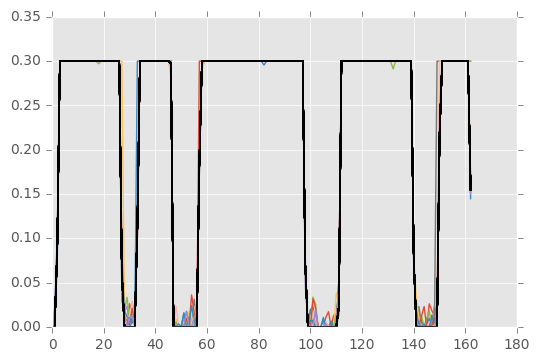

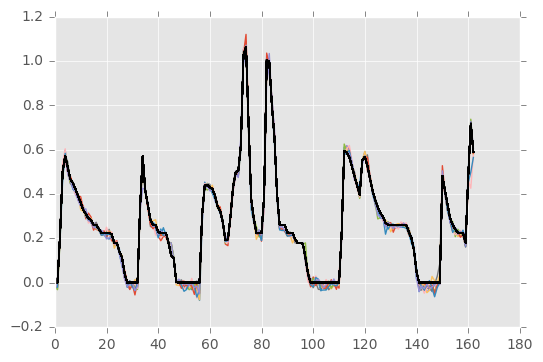

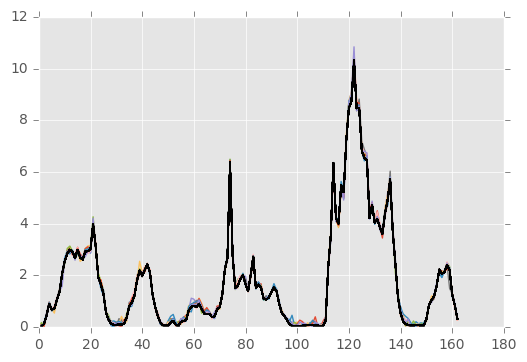

In [48]:
fit_pars = []
for i, fit in enumerate(ft):
    pred = fit[1]
    target = targets[i]
    fg = plt.figure()
    all_fits = np.reshape(pred.flatten(), (10, -1))
    plt.plot(all_fits.T);
    fit_pars.append(all_fits[0,:])
    plt.plot((target.T), 'k');

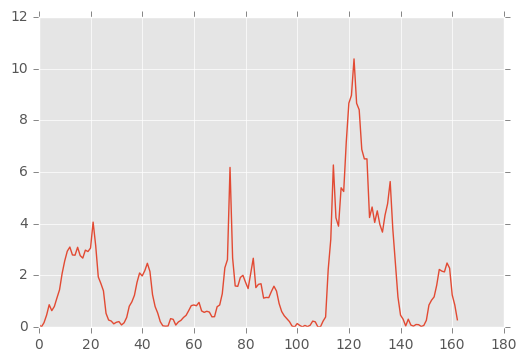

In [51]:
plt.plot(fit_pars[2])

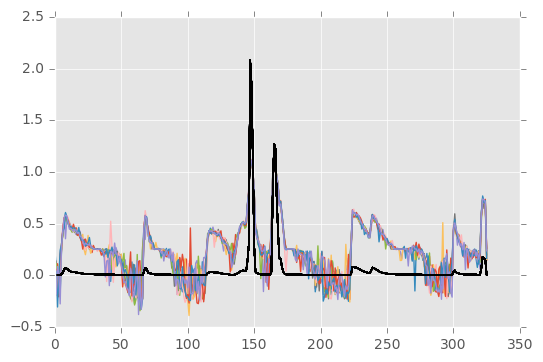

In [170]:
pred = model.predict(X_test, batch_size=15)
plt.plot(syn.np_mulog(np.reshape(pred.flatten(), (10, -1)).T))
plt.plot((target.T), 'k');

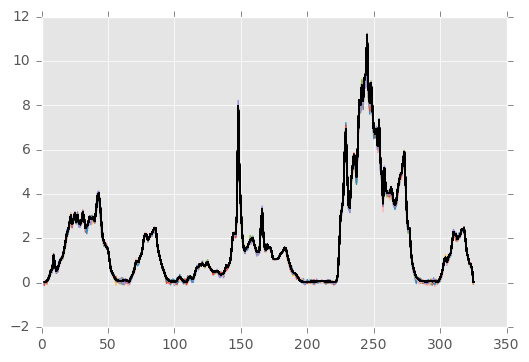

In [136]:
pred = model.predict(X_test, batch_size=15)
plt.plot(np.reshape(pred.flatten(), (10, -1)).T);
plt.plot(target.T, 'k');

In [92]:
def transform_env(x):
    x[x<0] = 0
    return x

def transform_alpha(x):
    x[x<0.15] = 0
    x[x>=.15] = .3
    return x

def transform_beta(x):
    x[x<0] = 0
    return x

def mu_transform_beta(x):
    x[x<0] = 0
    return syn.np_mulog_inv(x, 256)


def resample_no_interp(x, s_f, new_s_f, axis=0):
    assert(new_s_f>=s_f)
    n_repeats = np.int(np.ceil(new_s_f/s_f))
    return np.repeat(x, n_repeats, axis=axis)

def resample_interp(y, s_f, new_s_f):
    print s_f
    t = np.arange(y.size)/s_f
    print t[-1]
    print 1./new_s_f
    t_interp = np.arange(t[-1]*new_s_f)/new_s_f
    f = sp.interpolate.interp1d(t, y, kind='linear')
    return f, t, t_interp

def latent_to_stream(onof, beta, alpha):
    onof[onof>.3] = .3
    onof[onof<0] = 0
    alpha[alpha<0]=0
    alpha=alpha*1000.
    return np.vstack([0.15 - onof, -beta, alpha]).T


In [93]:
all_pars = latent_to_stream(fit_pars[0], syn.np_mulog_inv(fit_pars[1]), fit_pars[2])
res_pars = resample_no_interp(all_pars, 1000./bin_size, 44100.)

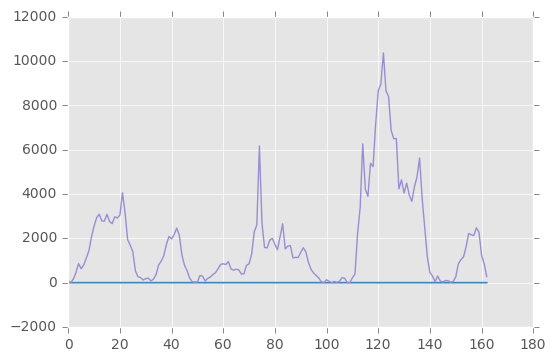

In [94]:
plt.plot(all_pars);

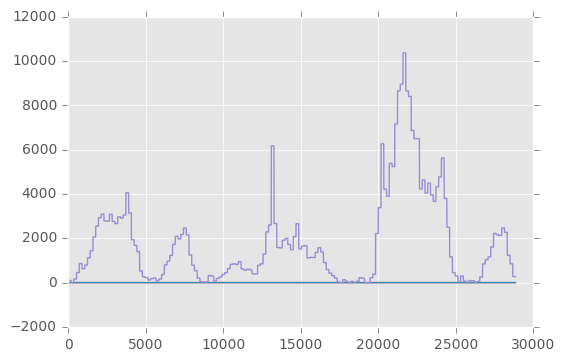

In [95]:
plt.plot(res_pars);

In [100]:
np.max(s_s[:, 0])

10373.494140625

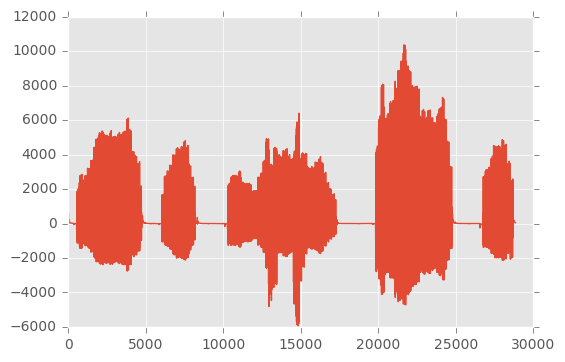

In [96]:
from dynamo import finch as zf
s_s = zf.make_song(res_pars)
plt.plot(s_s[:, 0])

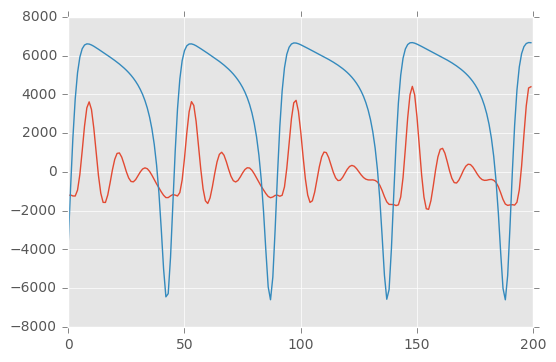

In [97]:
plt.plot(s_s[1500:1700, :])

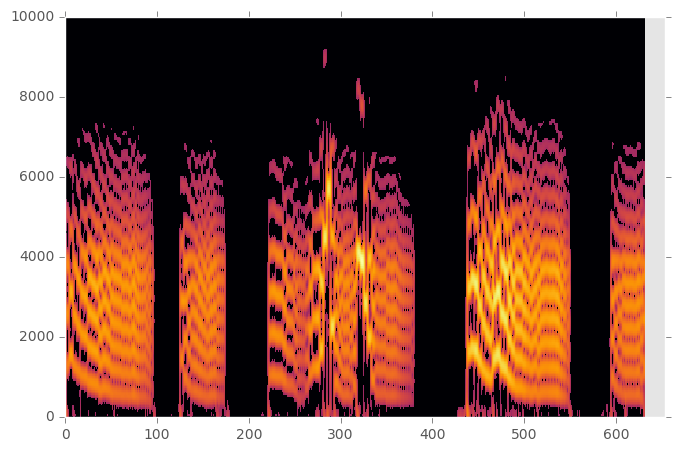

In [98]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True,
                 cmap='inferno')
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

spectr_bos, ax = plot_spectrogram(s_s[:, 0], 
                                   0, 0, 44100,
                                   n_window = 1024, n_overlap=1024-1, scaling='spectrum')

In [106]:
ax.figure.savefig(fig_fname, format='eps', dpi=300)

In [105]:
fig_fname = os.path.join(os.path.split(m_path)[0], 'ff_nn_synthesis.eps')
savefig(fig_fname, format='eps', dpi=300)

outwav = s_s[:, 0].astype(np.int16)
wav_fname = os.path.join(os.path.split(m_path)[0], 'ff_nn_synthesis_16.wav')
wavfile.write(wav_fname, 44100, outwav)

AttributeError: 'Axes' object has no attribute 'savefig'

In [88]:
os.path.split(m_path)[0]

'/mnt/cube/earneodo/bci_zf/stim_data/z007'

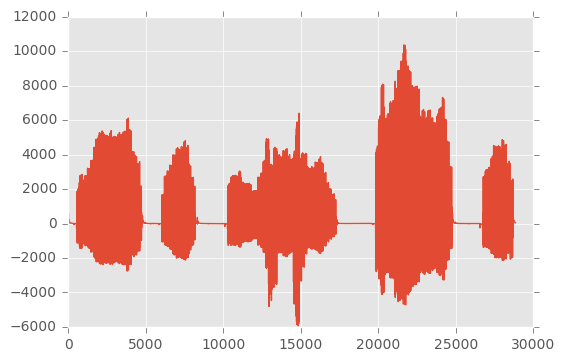

In [103]:
plt.plot(outwav)

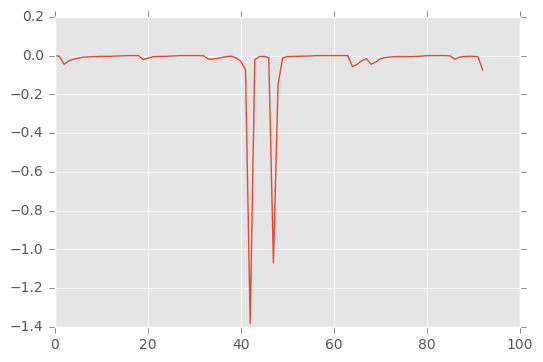

In [299]:
plt.plot(abe_streams[:,1])

In [316]:
resample_no_interp(arr, 1, 2, axis=0).shape

(6, 2)

2017-01-18 16:46:41,552 root         INFO     Testing for all pars with bin_size=7, history_size=15:
2017-01-18 16:46:43,023 root         INFO     sv shape (56, 108, 65), target shape (65, 93), len_samples 19503
2017-01-18 16:46:43,534 root         INFO     kernel shape (897,), sv_shape (56, 108, 6), len_samples 19503
2017-01-18 16:46:44,930 root         INFO     sv shape (56, 108, 65), target shape (65, 93), len_samples 19503
2017-01-18 16:46:45,365 root         INFO     kernel shape (897,), sv_shape (56, 108, 6), len_samples 19503
2017-01-18 16:46:46,700 root         INFO     sv shape (56, 108, 65), target shape (65, 93), len_samples 19503
2017-01-18 16:46:47,132 root         INFO     kernel shape (897,), sv_shape (56, 108, 6), len_samples 19503


In [283]:
every_test[3].shape

(3, 6, 93)

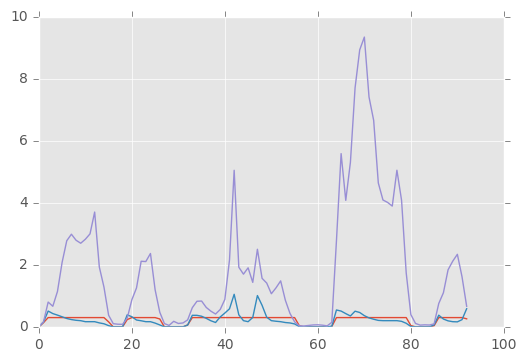

In [286]:
plt.plot(every_test[3][:, 0, :].T);

In [244]:
bins = [5, 6, 7, 8, 9, 10, 12, 15]
histories = [5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 22, 25, 27]
tests_sweep = []
for bs in bins:
    bs_sweep = []
    for hs in histories:
        logger.info('Testing with bs={0}, hs={1}:'.format(bs, hs))
        ev_tst = altogether_test(alpha, syn.np_mulog(beta, 256), envelope,
                             units_list,
                             motiff_starts_kwik[trials_train],
                             motiff_starts_kwik[trials_test], 
                             bin_size=bs, 
                             history_bins=hs, 
                             s_f=s_f, 
                             nl_alpha = transform_alpha, 
                             nl_beta = transform_beta, 
                             nl_env = transform_env
                            )
        bs_sweep.append(ev_tst)
    tests_sweep.append(bs_sweep)

2016-12-08 17:22:58,779 root         INFO     Testing with bs=5, hs=5:
2016-12-08 17:22:58,783 root         INFO     Testing for all pars with bin_size=5, history_size=5:
2016-12-08 17:23:01,944 root         INFO     kernel shape (337,), sv_shape (56, 136, 6), len_samples 19503
2016-12-08 17:23:04,908 root         INFO     kernel shape (337,), sv_shape (56, 136, 6), len_samples 19503
2016-12-08 17:23:07,814 root         INFO     kernel shape (337,), sv_shape (56, 136, 6), len_samples 19503
2016-12-08 17:23:07,821 root         INFO     Testing with bs=5, hs=6:
2016-12-08 17:23:07,822 root         INFO     Testing for all pars with bin_size=5, history_size=6:
2016-12-08 17:23:10,742 root         INFO     kernel shape (393,), sv_shape (56, 137, 6), len_samples 19503
2016-12-08 17:23:13,676 root         INFO     kernel shape (393,), sv_shape (56, 137, 6), len_samples 19503
2016-12-08 17:23:16,616 root         INFO     kernel shape (393,), sv_shape (56, 137, 6), len_samples 19503
2016-12-08

In [232]:
len(tests_sweep)
n_bs

7

In [235]:
tests_sweep[5][2][2]

array([ 0.18780506,  0.29427109,  0.18832537])

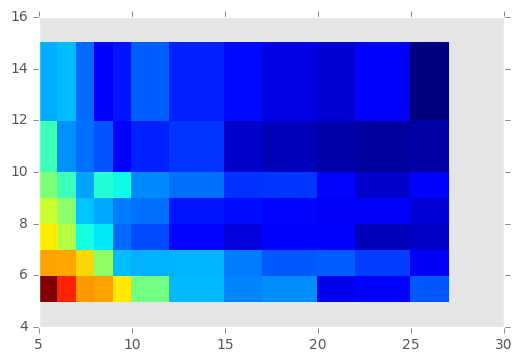

In [274]:
import itertools
n_bs = len(bins)
n_hs = len(histories)

res_array = np.zeros([n_bs, n_hs, 3])
for b, h in itertools.product(range(n_bs), range(n_hs)):
    res_array[b, h, :] = tests_sweep[b][h][2]

plt.pcolormesh(histories, bins, res_array[:,:,0])

(660,)


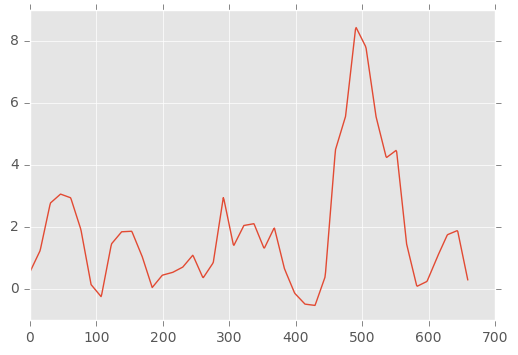

In [19]:
def resample_interp(x, s_f, new_s_f):
    t = np.linspace(0, x.size/s_f, x.size)
    #print t
    new_t = np.linspace(0, x.size/s_f, np.int(x.size*new_s_f/s_f))
    print new_t.shape
    return np.interp(new_t, t, x)

y = resample_interp(predict[3,:], 1, bin_size)
plt.plot(y)


In [23]:
ms_env.shape

(1, 651)

In [20]:
from decoder import linear
reload(ld)
big_r = ld.make_big_r(sv, history_bins)
big_r.shape

(2925, 1121)

In [21]:
def test_prediction(target, predict):
    

IndentationError: expected an indented block (<ipython-input-21-8dc4f6b324ac>, line 2)

In [100]:
motiff_starts_kwik = kwf.apply_rec_offset(kwik_file, vu.event.get_start(), vu.event.get_rec())
# make an array of n_bins * n_units * n_starts

bin_size = 5
history_bins = 20

# n_ms = int(len_samples/s_f*1000.)
# bin_size_samples = int(bin_size*s_f/1000)

# n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
# n_starts = motiff_starts_kwik.size
# n_units = all_units.size


# sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)
# model_pars = bp.col_binned(np.array([alpha, beta]), bin_size_samples)

# for i, unit_meta in enumerate(all_units):
#     clu = unit_meta['clu']
#     unit = Unit(clu, kwik_file=kwik_file)
#     rs = unit.get_raster(motiff_starts_kwik - int(history_bins*bin_size*s_f/1000), 
#                          n_ms + bin_size*(history_bins-1), 
#                          span_is_ms=True, 
#                          return_ms=True)
#     sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
# good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
# god_vec = sup_vec[good_units,:,:][0]

def gimme_good_vec(starts, len_samples, all_units, kwik_file, alpha, beta,
                   s_f=30000, bin_size=10, history_bins=1):
    n_ms = int(len_samples/s_f*1000.)
    bin_size_samples = int(bin_size*s_f/1000.)
    
    n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
    n_starts = starts.size
    n_units = all_units.size
    
    model_pars = bp.col_binned(np.array([alpha, beta, envelope]), bin_size_samples)
    sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)  
    for i, unit_meta in enumerate(all_units):
        clu = unit_meta['clu']
        unit = Unit(clu, kwik_file=kwik_file)
        rs = unit.get_raster(starts - int(history_bins*bin_size*s_f/1000), 
                             n_ms + bin_size*(history_bins-1), 
                             span_is_ms=True, 
                             return_ms=True)
        sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
    good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
    
    return sup_vec[good_units,:,:][0], model_pars

def unit_array(god_vec, i_u, i_tr, m, N):    
    x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
    return x

def all_units_array(god_vec, i_tr, m, N):
    x = np.hstack([unit_array(god_vec, u, i_tr, m, N) for u in range(god_vec.shape[0])])
    return np.hstack([np.ones([x.shape[0], 1]), x])

def fit_kernel(god_vec, target, trials, history_bins=10):
    # with this simple support vector make a linear decoder as in warland
    N = history_bins # history bins
    
    v = god_vec.shape[0] #number of units
    M = god_vec.shape[2] #len of recording
    m = M-N
    
    bigR = np.vstack([all_units_array(god_vec, i_tr, m, N) for i_tr in trials])
    s = np.tile(target[:m], trials.size)
    c = np.dot(bigR.T, bigR)
    rc = np.dot(bigR.T, s)
    f = np.dot(np.linalg.inv(c), rc)
    
    return f

def test_kernel(god_vec, target, kernel, trials, history_bins):
    N = history_bins
    M = god_vec.shape[2]
    m = M - N
    all_fits = np.vstack([np.dot(all_units_array(god_vec, tr_test, m, N), kernel) for tr_test in trials])
    all_fits[all_fits<0]=0
    
    all_residual = np.einsum('ij,ij', all_fits - target[:m], all_fits - target[:m])
    err = all_residual/np.einsum('i,i', target[:m], target[:m])  
    return err, all_fits


god_vec, model_pars = gimme_good_vec(motiff_starts_kwik, len_samples, all_units, kwik_file, alpha, beta, 
                                     s_f=30000, 
                                     bin_size=bin_size, 
                                     history_bins=1)

# with this simple support vector make a linear decoder as in warland
N = history_bins# history bins
M = god_vec.shape[2] #len of recording
m = M-N

n_trials = 65
f_fit_alpha = fit_kernel(god_vec, model_pars[0,:], np.arange(n_trials), history_bins=N)
f_fit_beta = fit_kernel(god_vec, model_pars[1,:], np.arange(n_trials), history_bins=N)
f_fit_env = fit_kernel(god_vec, model_pars[2,:], np.arange(n_trials), history_bins=N)
f_fit_betalog = fit_kernel(god_vec, mulog_vec(model_pars[1,:m]/350, 512), np.arange(n_trials), history_bins=N)

tr_test = 69
u_alpha = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_alpha)
u_beta = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_beta)
u_betalog = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_betalog)
u_env = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_env)

plt.plot(u_alpha)
plt.plot(model_pars[0,:m])

d, alfits = test_kernel(god_vec, model_pars[1,:], f_fit_beta, np.arange(67,69), N)


ValueError: could not broadcast input array from shape (71,137) into shape (71,138)

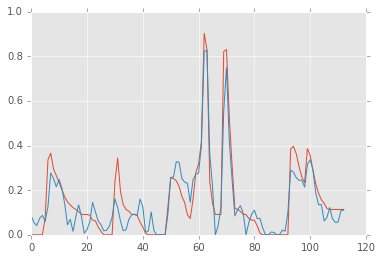

In [17]:
plt.plot(mulog_vec(model_pars[1,:m]/350, 512))
u_betalog[u_betalog<0]=0
plt.plot(u_betalog)

In [101]:
sup_vec

NameError: name 'sup_vec' is not defined

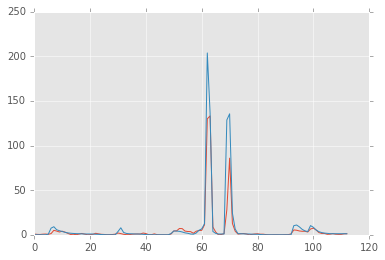

In [18]:
def inverse_mulog_vec(y, mu=256):
    return np.sign(y) * (np.power((1. + mu)*np.ones_like(y), np.fabs(y)) - 1.)/mu

beta = inverse_mulog_vec(u_betalog)*350
plt.plot(beta)
plt.plot(model_pars[1,:m])

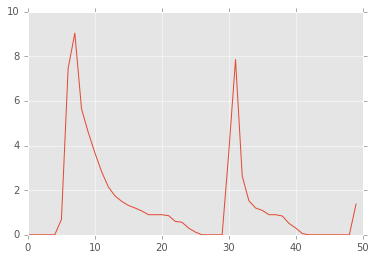

In [26]:
plt.plot(model_pars[1,:50])

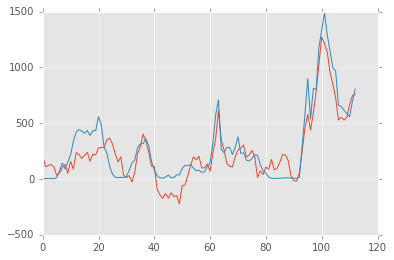

In [19]:
plt.plot(u_env)
plt.plot(model_pars[2,:m])

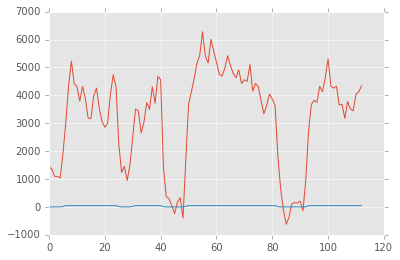

In [20]:
#u_alpha[u_alpha<45]=0.
#u_alpha[u_alpha>45]=-.15
plt.plot(u_alpha*100)
plt.plot(model_pars[0,:m])

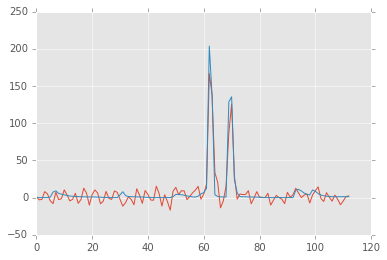

In [27]:
plt.plot(u_beta)
plt.plot(model_pars[1,:m])

In [21]:
def resample_interp(x, s_f, new_s_f):
    t = np.linspace(0, x.size/s_f, x.size)
    #print t
    new_t = np.linspace(0, x.size/s_f, np.int(x.size*new_s_f/s_f))
    print new_t.shape
    return np.interp(new_t, t, x)
